# Define bounding box around SF and Oakland

Use [bboxfinder](http://bboxfinder.com/) to draw bounding box around SF and Oakland.

In [1]:
%matplotlib inline
import IPython
url = 'http://bboxfinder.com/#37.665070,-122.598983,37.861302,-122.211227'
iframe = '<iframe src=' + url + ' width=100% height=600></iframe>'
IPython.display.HTML(iframe)

# Get all stop stations within bounding box with Transitland

Use Transitland API to get all stop stations within the bounding box.

In [2]:
import requests

In [3]:
%%time

mapzen_api_key = "mapzen-ai1duha"
bbox = "-122.598983,37.665070,-122.211227,37.861302"
response = requests.get("http://transit.land/api/v1/stop_stations?bbox={}&api_key={}&per_page=false&total=true".format(bbox, mapzen_api_key))
json_response = response.json()

print json_response['meta']['total'], "stop_stations in bounding box"
print len(json_response['stop_stations']), "stop_stations in json response"

5669 stop_stations in bounding box
5669 stop_stations in json response
CPU times: user 467 ms, sys: 77.3 ms, total: 544 ms
Wall time: 51.8 s


# Classify each stop station as either "simple stop" or "station"

Simple stops have all stop egresses and stop platforms with "generated = true". Add classification types to json.

In [4]:
def classify_stop_station_types(json_input):
    '''If a particular station has all stop egresses and stop platforms with
       generated = true, then it's just a simple stop. Otherwise, its a station.'''
    
    for stop_station in json_input:
        generated_or_not_generated = []
        
        for stop_egress in stop_station['stop_egresses']:
            generated_or_not_generated.append(stop_egress['generated'])
        for stop_platform in stop_station['stop_platforms']:
            generated_or_not_generated.append(stop_platform['generated'])
        
        if all(generated_or_not_generated):
            stop_station['stop_station_type'] = "Simple Stop"
        else:
            stop_station['stop_station_type'] = "Station"
            
    return json_input

In [5]:
json_input = json_response['stop_stations']
data = classify_stop_station_types(json_input)

# Create a dictionary out of the data to speed up search

In [6]:
def create_data_dict(data):
    data_dict = {}
    for i in data:
        onestop_id = i['onestop_id']
        data_dict[onestop_id] = i
        for stop_platform in i['stop_platforms']:
            onestop_id_ = stop_platform['onestop_id']
            data_dict[onestop_id_] = stop_platform
            data_dict[onestop_id_]['stop_station_type'] = 'Stop Platform'
    return data_dict

In [7]:
data_dict = create_data_dict(data)

# Get all of the stop stations for the map

In [8]:
def get_stop_stations_for_map(data):
    output = []
    
    for i in data:
        results = {}
        results['stop_station_lon'] = i['geometry']['coordinates'][0]
        results['stop_station_lat'] = i['geometry']['coordinates'][1]
        results['stop_station_name'] = str(i['name']).replace('"',"")
        results['operators_serving_stop_and_platforms'] = [str(j['operator_name']) for j in i['operators_serving_stop_and_platforms']]
        results['onestop_id'] = i['onestop_id']
        results['vehicle_types'] = i['vehicle_types_serving_stop_and_platforms']
        
        if i['stop_station_type'] == 'Station':
            if len(i['stop_platforms']) == 0:
                results['stop_station_type'] = 'Station w 0 Platforms'
            elif len(i['stop_platforms']) == 1:
                results['stop_station_type'] = 'Station w 1 Platform'
            elif len(i['stop_platforms']) == 2:
                results['stop_station_type'] = 'Station w 2 Platforms'
            elif len(i['stop_platforms']) > 2:
                results['stop_station_type'] = 'Station w >2 Platforms'            
        else:        
            results['stop_station_type'] = 'Simple Stop'
        
        results['number_of_stop_platforms'] = len(i['stop_platforms'])             
        output.append(results)

    return output

In [9]:
stop_stations_for_map = get_stop_stations_for_map(data)

# Get all of the stop platforms for the map

In [10]:
def get_stop_platforms_for_map(data):
    output = []
    for i in data:
        for stop_platform in i['stop_platforms']:
            platform = {}
            if stop_platform['generated'] == False:
                platform['parent_station_id'] = i['onestop_id']
                platform['parent_station_name'] = i['name']
                platform['stop_platform_lon'] = stop_platform['geometry']['coordinates'][0]
                platform['stop_platform_lat'] = stop_platform['geometry']['coordinates'][1]
                platform['operators_serving_stop_and_platforms'] = i['operators_serving_stop_and_platforms']
                platform['stop_station_type'] = "Stop Platform"
                platform['onestop_id'] = stop_platform['onestop_id']
                platform['vehicle_types'] = stop_platform['served_by_vehicle_types']
                output.append(platform)                    
    return output

In [11]:
stop_platforms_for_map = get_stop_platforms_for_map(data)

# Draw lines from station stops to stop platforms

In [12]:
def get_lines_for_map(data):
    lines = []
    for i in data:
        for stop_platform in i['stop_platforms']:
            if stop_platform['generated'] == False:
                stop_station_lon =  i['geometry']['coordinates'][0]
                stop_station_lat =  i['geometry']['coordinates'][1]
                stop_platform_lon = stop_platform['geometry']['coordinates'][0]
                stop_platform_lat = stop_platform['geometry']['coordinates'][1]
                line = [(stop_station_lat, stop_station_lon), (stop_platform_lat, stop_platform_lon)]
                lines.append(line)
                
    return lines

In [13]:
lines_for_map = get_lines_for_map(data)

# Throw it all on a map!

Map all of the stops, stations, plaforms and edges.

In [14]:
import folium

In [15]:
def make_map(stop_stations, stop_platforms, lines, bbox, basemap = 'Mapbox', save_to_html=False):
    
    # Calculate center location from bbox
    bbox_lons = [float(bbox.split(",")[0]), float(bbox.split(",")[2])]
    bbox_lats = [float(bbox.split(",")[1]), float(bbox.split(",")[3])]
    default_lon = sum(bbox_lons) / len(bbox_lons) # average lon
    default_lat = sum(bbox_lats) / len(bbox_lats) # average lat
    
    # Choose basemap (currently either Mapbox or OSM)
    if basemap == 'Mapbox':
        baseurl = 'http://{s}.tiles.mapbox.com/v4/mapbox.light/{z}/{x}/{y}.png'
        mapbox_api_key = 'pk.eyJ1Ijoid2lsbGdlYXJ5IiwiYSI6ImNpdW9wcmkxNjAxbDUydXQ0MzFwdmdvOWkifQ.9YIdQhYTOpRpocyFK-tBNA'
        token = '?access_token={}'.format(mapbox_api_key)
        m = folium.Map(location=[default_lat, default_lon], zoom_start=13, tiles=baseurl+token, attr='Mapbox')

    elif basemap == 'OSM':
        m = folium.Map(location=[default_lat, default_lon], zoom_start=13)
    
    # Define point color scheme
    colors = {'Simple Stop': '#3186cc', 
              'Station w 0 Platforms': '#fee5d9',
              'Station w 1 Platform': '#fc9272', 
              'Station w 2 Platforms': '#ef3b2c',
              'Station w >2 Platforms': '#99000d', 
              'Stop Platform': '#32CD32', 
              'Line': '#000000'}
    
    # Make radius bigger for stations with more platforms
    station_radius = {'Station w 0 Platforms': 3,
                      'Station w 1 Platform': 4,
                      'Station w 2 Platforms': 5,
                      'Station w >2 Platforms': 6,
                      'Simple Stop': 3}    
    
    # Draw lines
    for i in lines:
        folium.PolyLine(locations=i, color=colors['Line'], weight=2, opacity=1).add_to(m)
        
    # Draw stop_platforms
    for i in stop_platforms:
        popup_html = folium.Html('<b>Name: </b> {} <br> <b>Operators:</b> {} <br> <b>Type:</b> {} <br> <b>Vehicles:</b> {} <br> <b>Location:</b> {} <br> <b>Onestop-id:</b> {}'.format(i['parent_station_name'].replace("'",""), i['operators_serving_stop_and_platforms'][0]['operator_name'], i['stop_station_type'], ','.join(i['vehicle_types']), str([i['stop_platform_lat'], i['stop_platform_lon']]), i['onestop_id']), script=True)
        popup = folium.Popup(popup_html, max_width=2650)
        folium.CircleMarker(location=[i['stop_platform_lat'], i['stop_platform_lon']], radius=4,
                       popup=popup, color=colors[i['stop_station_type']], fill_opacity=0.8,
                       fill_color=colors[i['stop_station_type']]).add_to(m)
        
    # Draw station_stops
    for i in stop_stations:
        popup_html = folium.Html('<b>Name: </b> {} <br> <b>Operators:</b> {} <br> <b>Type:</b> {} <br> <b>Vehicles:</b> {} <br> <b>Location:</b> {} <br> <b>Onestop-id:</b> {}'.format(i['stop_station_name'].replace("'",""), ','.join(i['operators_serving_stop_and_platforms']), i['stop_station_type'], ','.join(i['vehicle_types']), str([i['stop_station_lat'], i['stop_station_lon']]), i['onestop_id']), script=True)
        popup = folium.Popup(popup_html, max_width=2650)
        folium.CircleMarker(location=[i['stop_station_lat'], i['stop_station_lon']], radius=station_radius[i['stop_station_type']],
                        popup=popup, color=colors[i['stop_station_type']], fill_opacity=0.8,
                        fill_color=colors[i['stop_station_type']]).add_to(m)

    # Optional save map to html
    if save_to_html:
        m.save(save_to_html)
    else:
        return m

In [16]:
%%time
make_map(stop_stations_for_map, stop_platforms_for_map, lines_for_map, bbox, save_to_html="../maps/map8.html")

CPU times: user 4min 29s, sys: 3.85 s, total: 4min 33s
Wall time: 4min 43s


In [135]:
url = 'https://willgeary.github.io/transitland_station_hierarchies/maps/map8.html'
iframe = '<iframe src=' + url + ' width=100% height=600></iframe>'
IPython.display.HTML(iframe)

# Make a station hierarchy network

In [18]:
import networkx as nx

In [19]:
nodes = [i for i in data]
stations = [i for i in data if i['stop_station_type'] == "Station"]
platforms = [i for i in data for stop_platform in i['stop_platforms'] if stop_platform['generated'] == False]
simple_stops = [i for i in data if i['stop_station_type'] == "Simple Stop"]

node_ids = [i['onestop_id'] for i in data]
station_ids = [i['onestop_id'] for i in data if i['stop_station_type'] == "Station"]
platform_ids = [i['onestop_id'] for i in data for stop_platform in i['stop_platforms'] if stop_platform['generated'] == False]
simple_stop_ids = [i['onestop_id'] for i in data if i['stop_station_type'] == "Simple Stop"]

print len(stations), "Stations"
print len(platforms), "Platforms"
print len(simple_stops), "Simple Stops"

20 Stations
88 Platforms
5649 Simple Stops


In [20]:
def get_edges(data):
    edges = []
    
    for station in data:
        source = station['onestop_id']
        for stop_platform in station['stop_platforms']:
            target = stop_platform['onestop_id']
            edge = (source, target)
            edges.append(edge)
            
    return edges

In [21]:
edges = get_edges(stations)

In [22]:
def make_graph(nodes, edges):
    g = nx.Graph()
    
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    
    return g

In [23]:
g = make_graph(node_ids, edges)

print len(g.nodes()), "nodes"
print len(g.edges()), "edges"

5757 nodes
88 edges


# Draw network

In [24]:
import plotly.plotly as py
from plotly.graph_objs import *

In [25]:
def draw_network(nodes, edges, layout=nx.shell_layout):
    '''
    Possible layouts:  ['circular_layout',
                        'random_layout',
                        'shell_layout',
                        'spring_layout',
                        'spectral_layout',
                        'fruchterman_reingold_layout']
    '''
    g=nx.Graph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    
    pos=layout(g)

    Xv=[pos[k][0] for k in g.nodes()]
    Yv=[pos[k][1] for k in g.nodes()]
    Xed=[]
    Yed=[]
    for edge in g.edges():
        Xed+=[pos[edge[0]][0],pos[edge[1]][0], None]
        Yed+=[pos[edge[0]][1],pos[edge[1]][1], None] 

    axis=dict(showline=False, # hide axis line, grid, ticklabels and  title
              zeroline=False, showgrid=False, showticklabels=False, title='')
    width=800
    height=800
    layout=Layout(title= "Station Hierarchy Network",  
        font= Font(size=12),
        showlegend=False, autosize=False, width=width, height=height, xaxis=XAxis(axis), yaxis=YAxis(axis),          
        margin=Margin(l=40, r=40, b=85, t=100,), hovermode='closest',)

    trace_edges=Scatter(x=Xed, y=Yed, mode='lines', line=Line(color='rgb(210,210,210)', width=1), hoverinfo='none')
    trace_nodes=Scatter(x=Xv, y=Yv, mode='markers', name='net',
                   marker=Marker(symbol='dot', size=10, color='#6959CD', line=Line(color='rgb(50,50,50)', width=0.5)),
                   text=g.nodes(), hoverinfo='text')

    graph_data=Data([trace_edges, trace_nodes])
    figure=Figure(data=graph_data, layout=layout)
    return py.iplot(figure, filename='Station Hierarchy Network')

In [27]:
%%time

draw_network(node_ids, edges, layout=nx.spring_layout)

CPU times: user 2min 16s, sys: 1.35 s, total: 2min 17s
Wall time: 2min 26s


# Make distance matrix between all stations and simple stops

In [62]:
import pandas as pd
from geopy.distance import vincenty

Note: Can also use api to query within a certain radius: http://transit.land//api/v1/stop_stations?lon=-121.977772198&lat=37.413530093&r=100

In [63]:
def make_distance_matrix(stations, simple_stops, data_dict):
    
    # Initialize empty dataframe to store results
    station_ids = [station['onestop_id'] for station in stations]
    simple_stop_ids = [simple_stop['onestop_id'] for simple_stop in simple_stops]
    distance_matrix = pd.DataFrame(index=station_ids, columns=simple_stop_ids)
    
    # Get locations for each station and simple stop pair
    for station in stations:
        station_id = station['onestop_id']
        station_lat = station['geometry']['coordinates'][1]
        station_lon = station['geometry']['coordinates'][0]
        station_location = (station_lat, station_lon)
        
        for simple_stop in simple_stops:
            simple_stop_id = simple_stop['onestop_id']
            simple_stop_lat = simple_stop['geometry']['coordinates'][1]
            simple_stop_lon = simple_stop['geometry']['coordinates'][0]
            simple_stop_location = (simple_stop_lat, simple_stop_lon)
            
            # Calculate distance in meters and store it in matrix
            distance = vincenty(station_location, simple_stop_location).meters
            distance_matrix.ix[station_id][simple_stop_id] = distance
            
    return distance_matrix

In [64]:
%%time

distance_matrix = make_distance_matrix(stations, simple_stops, data_dict)

CPU times: user 32.8 s, sys: 546 ms, total: 33.3 s
Wall time: 33.9 s


In [65]:
distance_matrix.head()

,s-9q9p616uyb-rockridge,s-9q9p1wrwrp-macarthur,s-9q9p1dwqv1-19thstoakland,s-9q9p19uw31-12thstoaklandcitycenter,s-9q9p145u1w-westoakland,s-9q8znb12j1-embarcadero,s-9q8yyxq427-montgomeryst,s-9q8yywd198-powellst,s-9q8yymt18w-civiccenter~unplaza,s-9q8yy6btqm-16thstmission,...,s-9q9p1wxf72-macarthur,s-9q8yyk3eds-missionst~southvannessave,s-9q8yycs1g5-22ndst~pennsylvaniaave,s-9q8yyct493-22ndst~iowast,s-9q8yycw746-22ndst~minnesotast,s-9q8yycxser-3rdst~22ndst,s-9q8yyct4bq-22ndst~iowast,s-9q8yych5sp-pennsylvaniaavenue~23rdstreet,s-9q8yybskfp-pennsylvaniaavenue~25thstreet,s-9q9ngh8rrh-highst~foothillblvd
s-9q9p1dh9te-14thst~broadway,4825.81,2782.97,519.505,51.6462,2091.34,11134.7,11537.7,12226.9,12861.3,13767,...,2782.97,13411.2,11901.4,11793.4,11649.8,11496.8,11793.1,12017.7,12128.5,6211.37
s-9q9p19eumv-11thst~broadway,5092.35,3044.52,784.13,217.288,2026.11,11019.8,11415.6,12095.8,12722.6,13604.3,...,3044.52,13261.5,11712.9,11604.3,11459.7,11306.1,11604.2,11825.4,11932.2,6162.5
s-9q9p19u1u7-12thst~broadway,4987.23,2938.52,680.746,114.335,2035.96,11053.4,11452.3,12136.3,12766.4,13658.4,...,2938.52,13310.1,11778.3,11670,11525.9,11372.5,11669.8,11892.5,12001.2,6192.73
s-9q9p4ckf4b-fruitvaleave~macarthurblvd,5828.7,5501.9,4697.98,4876.92,6966.41,15941.2,16321.2,16976.1,17575.6,18340,...,5501.9,18067.3,16276.6,16164,16012.8,15855.2,16165,16353.4,16420.9,2828.4
s-9q9p4tc63j-highlandave~highlandway,2768.73,3107.09,3703.79,4186.58,5980.15,14951.1,15391.9,16125.2,16796.1,17808.2,...,3107.09,17397.2,16026.7,15920.1,15778.6,15627.1,15919.5,16150.9,16268.8,5841.73


# Get all simple stops within 200 meters of a particular station

In [66]:
import numpy as np

In [67]:
def get_nearby_stop_ids(station_id, distance_matrix, radius = 200):
    '''Returns a list of all the onestop-ids within radius of station'''
    
    d = distance_matrix.ix[station_id]
    stop_ids = [d.index[i].values for i in np.where(d < radius)][0]
    
    return stop_ids.tolist()

In [68]:
def get_nearby_stops(station_id, distance_matrix, data, radius = 200):
    '''Returns a list of all the entire records with radius of station'''
    
    stop_ids = get_nearby_stop_ids(station_id, distance_matrix, radius=radius)
    
    stop_records = []
    for stop_id in stop_ids:
        stop_record = filter(lambda i: i['onestop_id'] == stop_id, data['stop_stations'])
        stop_records.append(stop_record[0])
        
    print len(stop_records), "records."
    return stop_records

# Example: 14th St and Broadway AC Transit Station

Here are the four simple stop ids within 200 meters of the 14th St and Broadway AC Transit station:

In [69]:
get_nearby_stop_ids('s-9q9p1dh9te-14thst~broadway', distance_matrix, radius=200)

[u's-9q9p19uw31-12thstoaklandcitycenter',
 u's-9q9p1d5q87-14thst~clayst',
 u's-9q9p19vx61-14thst~franklinst',
 u's-9q9p19vzs8-14thst~franklinst']

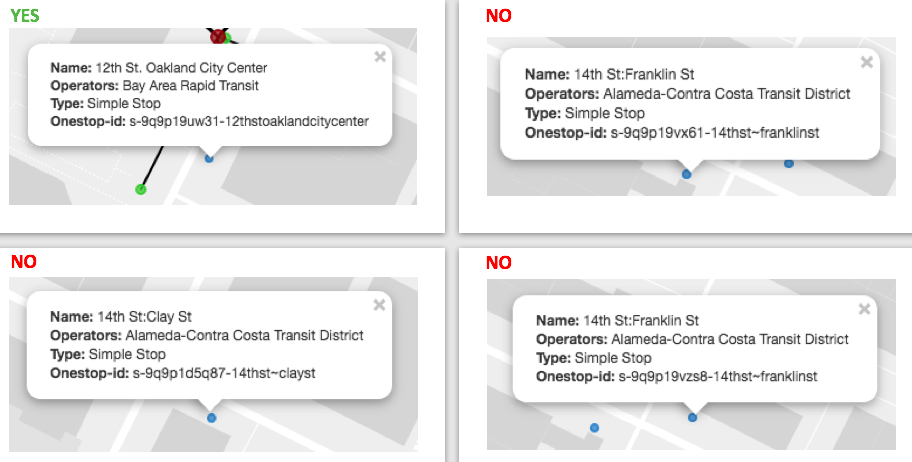

In [70]:
from IPython.display import Image
Image("../images/quadrant.png")

Variables to consider in algorithm:

- Name 1 vs Name 2
- Cross street 1 (if relevant)
- Cross street 2 (if relevant)
- Operator1 != Operator2
- Distance between 1 and 2
- Address 1 vs Address 2
- Coordinates 1 vs Coordinates 2
- Building footprints
- Building heights
- Served by vehicle type [bus, metro, tram, etc]
- Bigger radius by vehicle type
- Draw radius around any stop served by metro, tram or rail or is existing station
- Will and ian to label training data set next week
- Include vehicle type in popup
- Initial similarity matrix (distance *0.5 + name * 0.5)
- Use who's on first
- Stop_transfers
- ScheduleStopPairs (SSPs) to gauge a station or stops importance

Some questions...

- Is it safe to assume that if the operator of the station is equal to the operator of the simple stop, then the simple stop should not be considered a stop platform (since it would already be categorized as such if its the same operator)

- In other words... should a stop get more similarity points if the operator is different than the station?

# Fuzzy String Matching

In [71]:
from fuzzywuzzy import fuzz

Example string similarity score:

In [72]:
string1 = "14TH ST. & BROADWAY"
string2 = "12th St. Oakland City Center"
fuzz.token_sort_ratio(string1, string2)/100.0

0.51

# Make Similarity Matrix

In [73]:
def make_similarity_matrix(stations, platforms, simple_stops, distance_matrix, data_dict):

    # Initialize empty dataframe to store results
    station_ids = [station['onestop_id'] for station in stations]
    simple_stop_ids = [simple_stop['onestop_id'] for simple_stop in simple_stops]
    similarity_matrix = pd.DataFrame(index=station_ids, columns=simple_stop_ids)
    
    # Names dict with onestop_id keys
    names = {}
    for station in data_dict.keys():
        names[station] = data_dict[station]['name']
    
    # Get distance and name similarity between each station and simple stop pair
    for station_id in station_ids:
        station_name = names[station_id]
        for simple_stop_id in simple_stop_ids:
            simple_stop_name = names[simple_stop_id]
            name_similarity = fuzz.token_sort_ratio(station_name, simple_stop_name)/100.0
            
            distance = distance_matrix.ix[station_id][simple_stop_id]
            inverse_log_distance = 1 / np.log(distance)
            
            similarity_score = (name_similarity * 0.1) + (inverse_log_distance * 0.9)
            similarity_matrix.ix[station_id][simple_stop_id] = similarity_score
            
    return similarity_matrix

In [74]:
%%time

similarity_matrix = make_similarity_matrix(stations, platforms, simple_stops, distance_matrix, data_dict)

CPU times: user 59.4 s, sys: 959 ms, total: 1min
Wall time: 1min 2s


In [75]:
similarity_matrix.head()

,s-9q9p616uyb-rockridge,s-9q9p1wrwrp-macarthur,s-9q9p1dwqv1-19thstoakland,s-9q9p19uw31-12thstoaklandcitycenter,s-9q9p145u1w-westoakland,s-9q8znb12j1-embarcadero,s-9q8yyxq427-montgomeryst,s-9q8yywd198-powellst,s-9q8yymt18w-civiccenter~unplaza,s-9q8yy6btqm-16thstmission,...,s-9q9p1wxf72-macarthur,s-9q8yyk3eds-missionst~southvannessave,s-9q8yycs1g5-22ndst~pennsylvaniaave,s-9q8yyct493-22ndst~iowast,s-9q8yycw746-22ndst~minnesotast,s-9q8yycxser-3rdst~22ndst,s-9q8yyct4bq-22ndst~iowast,s-9q8yych5sp-pennsylvaniaavenue~23rdstreet,s-9q8yybskfp-pennsylvaniaavenue~25thstreet,s-9q9ngh8rrh-highst~foothillblvd
s-9q9p1dh9te-14thst~broadway,0.13011,0.137475,0.208934,0.279171,0.160715,0.126589,0.137222,0.135629,0.122118,0.146438,...,0.137475,0.116698,0.125904,0.140997,0.129123,0.136259,0.140997,0.125804,0.129711,0.135044
s-9q9p19eumv-11thst~broadway,0.129442,0.136204,0.200042,0.218248,0.161205,0.126697,0.137332,0.135738,0.122227,0.146556,...,0.136204,0.11681,0.126067,0.141163,0.129292,0.136431,0.141163,0.125969,0.129877,0.135137
s-9q9p19u1u7-12thst~broadway,0.1297,0.136702,0.202969,0.245908,0.16113,0.126665,0.137298,0.135704,0.122192,0.146517,...,0.136702,0.116774,0.13101,0.148105,0.135233,0.143371,0.148105,0.129911,0.133818,0.135079
s-9q9p4ckf4b-fruitvaleave~macarthurblvd,0.1198,0.153495,0.129447,0.134979,0.131708,0.124007,0.112781,0.119407,0.125079,0.110679,...,0.153495,0.123819,0.130808,0.120874,0.121964,0.122059,0.120873,0.129763,0.129723,0.154244
s-9q9p4tc63j-highlandave~highlandway,0.131548,0.12992,0.144528,0.142918,0.141493,0.115628,0.109346,0.116897,0.122508,0.116955,...,0.12992,0.129175,0.133956,0.12302,0.120106,0.119199,0.12302,0.128882,0.128812,0.151773


# Draw Similarity Heatmap

In [76]:
def reindex_matrix(similarity_matrix):
    '''Reindexes row and column names for heatmap'''
    plotdata = similarity_matrix.copy()
    plotdata.reset_index(inplace=True, drop=True)
    plotdata.columns = range(len(plotdata.columns))
    return plotdata

def similarity_heatmap(similarity_matrix, title='Similarity Matrix', filename='heatmap1'):
    '''Creates heatmap from the reindexed similarity matrix'''
    plotdata = reindex_matrix(similarity_matrix)
    
    data = [Heatmap(
        z = plotdata.values.tolist(), #zmin = 0, #zmax = 1,
        colorscale ='Viridis')]
    
    layout=Layout(
        title = title,
        xaxis = {'title':'Simple Stops'},
        yaxis = {'title':'Stations'}
    )
    
    figure= Figure(data=data,layout=layout)
    return py.iplot(figure, filename=filename)

In [77]:
%%time

similarity_heatmap(similarity_matrix)

CPU times: user 1.55 s, sys: 66.1 ms, total: 1.62 s
Wall time: 9.06 s


In [78]:
def get_score(station_number, stop_number, similarity_matrix):
    rows_dict = dict(zip(range(similarity_matrix.shape[0]), list(similarity_matrix.index)))
    cols_dict = dict(zip(range(similarity_matrix.shape[1]), list(similarity_matrix.columns)))
    row_id = rows_dict[station_number]
    col_id = cols_dict[stop_number]
    score = similarity_matrix.ix[row_id][col_id]
    return score

In [79]:
def compare_results(station_number, stop_number, similarity_matrix, data_dict):
    rows_dict = dict(zip(range(similarity_matrix.shape[0]), list(similarity_matrix.index)))
    cols_dict = dict(zip(range(similarity_matrix.shape[1]), list(similarity_matrix.columns)))
    row_id = rows_dict[station_number]
    col_id = cols_dict[stop_number]
    station_record = data_dict[row_id]
    simple_stop_record = data_dict[col_id]
    
    print "#### Station Record ####"
    print 'Name:', station_record['name']
    print 'Operators:', station_record['operators_serving_stop_and_platforms'][0]['operator_name']
    print 'Served by:', station_record['vehicle_types_serving_stop_and_platforms']
    print 'Onestop-id:', station_record['onestop_id']
    print 'Long, Lat:', station_record['geometry']['coordinates']
    print ""
    print "#### Simple Stop Record ####"
    print 'Name:', simple_stop_record['name']
    print 'Operators:', simple_stop_record['operators_serving_stop_and_platforms'][0]['operator_name']
    print 'Served by:', simple_stop_record['vehicle_types_serving_stop_and_platforms']
    print 'Onestop-id:', simple_stop_record['onestop_id']
    print 'Long, Lat:', simple_stop_record['geometry']['coordinates']
    print ""   
    print "#### Similarity Score ####"
    print 'Similarity Score:', get_score(station_number, stop_number, similarity_matrix)
    print 'Distance:', distance_matrix.ix[station_record['onestop_id']][simple_stop_record['onestop_id']], "meters"
    
    return [simple_stop_record['geometry']['coordinates'], station_record['geometry']['coordinates']]

In [80]:
comparison = compare_results(8, 5553, similarity_matrix, data_dict)

#### Station Record ####
Name: 40TH ST. & SAN PABLO AVE.
Operators: Alameda-Contra Costa Transit District
Served by: [u'bus']
Onestop-id: s-9q9p1qzn8j-40thst~sanpabloave
Long, Lat: [-122.279198, 37.831195]

#### Simple Stop Record ####
Name: 40th at San Pablo
Operators: Emery Go-Round
Served by: [u'bus']
Onestop-id: s-9q9p1qyz5e-40thatsanpablo
Long, Lat: [-122.279397282198, 37.8312685253329]

#### Similarity Score ####
Similarity Score: 0.387784551273
Distance: 19.348714189 meters


# View satellite imagery

In [81]:
import cesiumpy
%matplotlib inline

In [82]:
def fly_to_point(comparison, terrain = False):
    if terrain == True:
        url = '//assets.agi.com/stk-terrain/world'
        terrainProvider = cesiumpy.CesiumTerrainProvider(url=url)
        v = cesiumpy.Viewer(terrainProvider=terrainProvider)
    else:
        v = cesiumpy.Viewer()
        v.camera.flyTo((comparison[0][0], comparison[0][1], 200))
    
    stop_pin = cesiumpy.Pin.fromText('STOP', color=cesiumpy.color.BLUE)
    stop_bill = cesiumpy.Billboard(position=[comparison[0][0], comparison[0][1]], image=stop_pin)
    station_pin = cesiumpy.Pin.fromText('STAT', color=cesiumpy.color.RED)
    station_bill = cesiumpy.Billboard(position=[comparison[1][0], comparison[1][1]], image=station_pin)
    v.entities.add(stop_bill)
    v.entities.add(station_bill)
    
    return v

In [ ]:
fly_to_point(comparison)

# Map Station Merging Google Sheet

In [83]:
import pandas as pd

In [84]:
# Copy and paste entire Station merging sheet: https://docs.google.com/spreadsheets/d/1bcfFH-fHUwlSsLRaRWNI8wIjjGAfWwTJyvKW3Lqmv-c/edit?ts=5951568d#gid=0
df = pd.read_clipboard()

In [85]:
df.head()

,Station,Stop,Operator,Name,Distance,Route,SSPs,Merge?,Parent ID
0,s-9q8ymhqbcv-colma,s-9q8ymhqf6d-colmabart~bay6,o-9q8-samtrans,colma bart-bay 6,26.957863,1,172,Yes,s-9q8ymhqbcv-colma
1,s-9q8ymhqbcv-colma,s-9q8ymhr0g8-colmabart~bay5,o-9q8-samtrans,colma bart-bay 5,36.831951,1,177,Yes,s-9q8ymhqbcv-colma
2,s-9q8ymhqbcv-colma,s-9q8ymhr1u5-colmabart~bay11,o-9q8-samtrans,colma bart-bay 11,41.959033,1,179,Yes,s-9q8ymhqbcv-colma
3,s-9q8ymhqbcv-colma,s-9q8ymhqghh-colmabart~bay12,o-9q8-samtrans,colma bart-bay 12,42.928635,1,60,Yes,s-9q8ymhqbcv-colma
4,s-9q8ymhqbcv-colma,s-9q8ymhqejn-colmabart~bay7,o-9q8-samtrans,colma bart-bay 7,46.712936,1,0,Yes,s-9q8ymhqbcv-colma


In [86]:
# Check what's missing
print sum([i in data_dict.keys() for i in np.unique(df['Stop'])]), "Stop ID's found."
print len(np.unique(df['Stop'])) - sum([i in data_dict.keys() for i in np.unique(df['Stop'])]), "Stop ID's missing."
print ""
print sum([i in data_dict.keys() for i in np.unique(df['Station'])]), "Station ID's found."
print len(df['Stop']) - sum([i in data_dict.keys() for i in df['Station']]), "Station ID's missing."
print ""

376 Stop ID's found.
5 Stop ID's missing.

44 Station ID's found.
0 Station ID's missing.



In [87]:
# Augment data dictionary with the missing values
def augment_data_dict(df, data_dict):
    missing_ids = [i for i in np.unique(df['Stop']) if i not in data_dict.keys()]
    print "Getting", len(missing_ids), "missing ids."
    for i in missing_ids:
        url = "https://transit.land/api/v1/onestop_id/{}".format(i)
        response = requests.get(url)
        data = response.json()
        data_dict[i] = data
        try:
            for stop_egress in i['stop_egresses']:
                generated_or_not_generated.append(stop_egress['generated'])
            for stop_platform in i['stop_platforms']:
                generated_or_not_generated.append(stop_platform['generated'])
            if all(generated_or_not_generated):
                data_dict[i]['stop_station_type'] = "Simple Stop"
            else:
                data_dict[i]['stop_station_type'] = "Station"   
        except:
            data_dict[i]['stop_station_type'] = 'Stop Platform'

    return data_dict

In [88]:
data_dict = augment_data_dict(df, data_dict)

Getting 5 missing ids.


# Make a network

In [89]:
g2 = make_graph(list(np.unique(df['Station'])) + list(np.unique(df['Stop'])), list(zip(df.Station, df.Stop)))

In [98]:
draw_network(g2.nodes(), g2.edges(), layout=nx.spring_layout)

# Which edges are new?

In [91]:
def get_new_edges(g, g2):
    new_edges = []
    for edge in g2.edges():
        if edge not in g.edges():
            new_edges.append(edge)
    return new_edges

In [92]:
new_edges = get_new_edges(g, g2)

# Map the new edges

In [160]:
def make_map_of_csv(g, g2, df, data_dict = data_dict, basemap='Mapbox', save_to_html = False):
    centerLat = np.average([data_dict[i]['geometry']['coordinates'][1] for i in df['Station']])
    centerLon = np.average([data_dict[i]['geometry']['coordinates'][0] for i in df['Station']])
    new_edges = get_new_edges(g, g2)
    
    # Choose basemap (currently either Mapbox or OSM)
    if basemap == 'Mapbox':
        baseurl = 'http://{s}.tiles.mapbox.com/v4/mapbox.light/{z}/{x}/{y}.png'
        mapbox_api_key = 'pk.eyJ1Ijoid2lsbGdlYXJ5IiwiYSI6ImNpdW9wcmkxNjAxbDUydXQ0MzFwdmdvOWkifQ.9YIdQhYTOpRpocyFK-tBNA'
        token = '?access_token={}'.format(mapbox_api_key)
        m = folium.Map(location=[centerLat, centerLon], zoom_start=13, tiles=baseurl+token, attr='Mapbox')

    elif basemap == 'OSM':
        m = folium.Map(location=[centerLat, centerLon], zoom_start=13)
        
    # Draw existing edges (Black)
    for i in g.edges():
        source = i[0]
        target = i[1]
        source_name = data_dict[source]['name']
        target_name = data_dict[target]['name']
        source_lat = data_dict[source]['geometry']['coordinates'][1]
        source_lon = data_dict[source]['geometry']['coordinates'][0]
        target_lat = data_dict[target]['geometry']['coordinates'][1]
        target_lon = data_dict[target]['geometry']['coordinates'][0]
        edge_type = "Existing edge"
        
        popup_html = folium.Html('<b>Station Name: </b> {} <br> <b>Stop Name: </b> {} <br> <b>Station ID: </b> {} <br> <b>Stop ID: </b> {} <br> <b>Type: </b> {}'.format(source_name, target_name, source, target, edge_type), script=True)
        popup = folium.Popup(popup_html, max_width=2650)
        folium.PolyLine(popup=popup, locations=[(source_lat, source_lon), (target_lat, target_lon)], color='Black', weight=6, opacity=1).add_to(m)
    
    # Draw new edges (Purple)
    for i in new_edges:
        source = i[0]
        target = i[1]
        source_name = data_dict[source]['name']
        target_name = data_dict[target]['name']
        source_lat = data_dict[source]['geometry']['coordinates'][1]
        source_lon = data_dict[source]['geometry']['coordinates'][0]
        target_lat = data_dict[target]['geometry']['coordinates'][1]
        target_lon = data_dict[target]['geometry']['coordinates'][0]
        edge_type = "Potential edge"
        
        popup_html = folium.Html('<b>Station Name: </b> {} <br> <b>Stop Name: </b> {} <br> <b>Station ID: </b> {} <br> <b>Stop ID: </b> {} <br> <b>Type: </b> {}'.format(source_name, target_name, source, target, edge_type), script=True)
        popup = folium.Popup(popup_html, max_width=2650)
        folium.PolyLine(popup=popup, locations=[(source_lat, source_lon), (target_lat, target_lon)], color='Purple', weight=1, opacity=0.8).add_to(m)
    
    
    # Define point color scheme
    colors = {'Simple Stop': '#3186cc', 
              'Station': '#ef3b2c',
              'Stop Platform': '#32CD32', 
              'Line': '#000000'}
    
    # Draw nodes  
    for i in g2.nodes():
        
        # Get text for popup
        name = data_dict[i]['name']
        try: 
            operators = ','.join(data_dict[i]['operators_serving_stop_and_platforms']['operator_name'])
        except:
            operators = " "
        stop_station_type = data_dict[i]['stop_station_type']
        try:
            vehicles = ','.join(data_dict[i]['vehicle_types_serving_stop_and_platforms'])
        except:
            vehicles = " "
        location = str(data_dict[i]['geometry']['coordinates'])
        onestop_id = data_dict[i]['onestop_id']
                
        popup_html = folium.Html("<b>Name: </b> {} <br> <b>Operators: </b> {} <br> <b>Type:</b> {} <br> <b>Vehicles:</b> {} <br> <b>Location:</b> {} <br> <b>Onestop-id:</b> {}".format(name, operators, stop_station_type, vehicles, location, onestop_id), script=True)
        popup = folium.Popup(popup_html, max_width=2650)
        folium.CircleMarker(location=[data_dict[i]['geometry']['coordinates'][1], data_dict[i]['geometry']['coordinates'][0]], radius=4,
                        popup=popup, color=colors[data_dict[i]['stop_station_type']], fill_opacity=0.8,
                        fill_color=colors[data_dict[i]['stop_station_type']]).add_to(m)
    
    # Optional save map to html
    if save_to_html:
        m.save(save_to_html)
    else:
        return m

In [161]:
%%time

make_map_of_csv(g, g2, df)

CPU times: user 43.9 s, sys: 493 ms, total: 44.4 s
Wall time: 46 s


# Some notes and other things...

# Function to draw a circle in GeoJSON

In [641]:
import math

In [651]:
def make_geojson_circle(centerLat, centerLon, radius=200.0):
# code from: https://stackoverflow.com/questions/15886846/python-elegant-way-of-finding-the-gps-coodinates-of-a-circle-around-a-certain-g

    # inputs
    radius = radius # m - the following code is an approximation that stays reasonably accurate for distances < 100km
    centerLat = centerLat # latitude of circle center, decimal degrees
    centerLon = centerLon # Longitude of circle center, decimal degrees

    # parameters
    N = 10 # number of discrete sample points to be generated along the circle

    output = {
        "type": "FeatureCollection",
        "features": [
          {
          "type": "Feature",
          "properties": {
              "style":{
                "fill":"red",
                "stroke-width":"3",
                "fill-opacity":0.6
            }},
          "geometry": {
            "type": "Polygon",
            "coordinates": [],
          }
          }
        ]
    }


    # generate points
    circlePoints = []
    for k in xrange(N):
        # compute
        angle = math.pi*2*k/N
        dx = radius*math.cos(angle)
        dy = radius*math.sin(angle)
        point = []
        point.append(centerLon + (180/math.pi)*(dx/6378137)/math.cos(centerLat*math.pi/180))
        point.append(centerLat + (180/math.pi)*(dy/6378137))
        # add to list
        output['features'][0]['geometry']['coordinates'].append([point])
        
    return output

In [647]:
circle = make_geojson_circle(38, -122, 2000)

In [ ]:
test = folium.Map(location=[38.0, -122.0],
                   tiles='Mapbox Bright', zoom_start=11)

folium.GeoJson(circle,
              style_function=lambda feature: {
        'color': "red",
        #'color' : "#3186cc",
        'weight' : 10,
        'fillOpacity' : 1,
        }).add_to(test)

test